In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.transforms import Compose
torch.backends.cudnn.benchmark=True
from torch.optim import lr_scheduler

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!unzip "/content/gdrive/My Drive/train.zip"

In [4]:
!unzip "/content/gdrive/My Drive/test.zip"

Archive:  /content/gdrive/My Drive/test.zip
replace test/benign/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

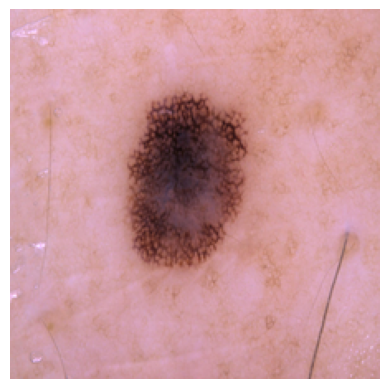

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    try:
        # Load and display the image
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axis labels and ticks
        plt.show()
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    image_path = "/content/train/benign/100.jpg"  # Replace with your image file path
    show_image(image_path)


In [5]:
classes_pc = 2
num_clients = 10
num_selected = 3
num_rounds = 6
epochs = 50
batch_size =32
baseline_num = 100
retrain_epochs = 60

In [6]:
from PIL import Image

directory_benign_train = '/content/train/benign'
directory_malignant_train = '/content/train/malignant'
directory_benign_test = '/content/test/benign'
directory_malignant_test = '/content/test/malignant'

def read(image_path):
    image = Image.open(image_path)
    # Convert image to RGB if it has more than 3 channels
    if image.mode != 'RGB':
        image = image.convert('RGB')
    return np.asarray(image)

# Loading train images
img_benign_train = [read(os.path.join(directory_benign_train, filename)) for filename in os.listdir(directory_benign_train)]
img_malignant_train = [read(os.path.join(directory_malignant_train, filename)) for filename in os.listdir(directory_malignant_train)]

# Loading test images
img_benign_test = [read(os.path.join(directory_benign_test, filename)) for filename in os.listdir(directory_benign_test)]
img_malignant_test = [read(os.path.join(directory_malignant_test, filename)) for filename in os.listdir(directory_malignant_test)]

#img_benign_train
img_benign_train

# Converting list to numpy array for faster and more convenient operations going forward

X_benign_train = np.array(img_benign_train, dtype='uint8')
X_malignant_train = np.array(img_malignant_train, dtype='uint8')

X_benign_test = np.array(img_benign_test, dtype='uint8')
X_malignant_test = np.array(img_malignant_test, dtype='uint8')


y_benign_train = np.zeros(X_benign_train.shape[0])
y_malignant_train = np.ones(X_malignant_train.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

y_malignant_train

X_train = np.concatenate((X_benign_train, X_malignant_train), axis=0)
Y_train = np.concatenate((y_benign_train, y_malignant_train), axis=0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis=0)
Y_test = np.concatenate((y_benign_test, y_malignant_test), axis=0)




In [8]:
s1 = np.arange(X_train.shape[0])
np.random.shuffle(s1)
X_train = X_train[s1]
y_train = Y_train[s1]

s2 = np.arange(X_test.shape[0])
np.random.shuffle(s2)
X_test =X_test[s2]
y_test = Y_test[s2]



X_train=X_train.transpose(0,3,1,2)
X_test=X_test.transpose(0,3,1,2)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", Y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (2637, 224, 3, 224)
Shape of y_train:  (2637,)
Shape of X_test:  (660, 224, 3, 224)
Shape of y_test:  (660,)


In [9]:
def get_sk():

    x_train, y_train = X_train, Y_train
    x_test, y_test = X_test, Y_test
    validation_split = 0.1
    random_seed = 42
    np.random.seed(random_seed)


    num_samples = len(x_train)
    num_validation_samples = int(validation_split * num_samples)
    indices = np.random.permutation(num_samples)
    validation_indices = indices[:num_validation_samples]
    x_val = x_train[validation_indices]
    y_val = y_train[validation_indices]

    x_train = np.delete( x_train, validation_indices, axis=0)
    y_train = np.delete( y_train, validation_indices, axis=0)

    return x_train, y_train, x_val, y_val, x_test, y_test


def clients_rand2(train_len, nclients):
    '''
    train_len: size of the train data
    nclients: number of clients

    Returns: to_ret

    This function creates a random distribution
    for the clients, i.e. the number of images each client
    possesses. The sum of elements will be 2110, and all elements
    will be greater than 200 and positive.
    '''
    client_tmp = []

    while True:

        client_tmp = [random.randint(200, train_len // nclients) for _ in range(nclients - 1)]
        last_client_value = train_len - sum(client_tmp)

        if last_client_value > 200:
            client_tmp.append(last_client_value)
            break

    random.shuffle(client_tmp)
    client_tmp = np.array(client_tmp)
    clients_dist = ((client_tmp / client_tmp.sum()) * train_len).astype(int)

    return list(clients_dist)

def clients_rand(train_len, nclients):
  '''
  train_len: size of the train data
  nclients: number of clients

  Returns: to_ret

  This function creates a random distribution
  for the clients, i.e. number of images each client
  possess.
  '''
  client_tmp=[]
  sum_=0
  #### creating random values for each client ####
  for i in range(nclients-1):
    tmp=random.randint(10,100)
    sum_+=tmp
    client_tmp.append(tmp)

  client_tmp= np.array(client_tmp)
  #### using those random values as weights ####
  clients_dist= ((client_tmp/sum_)*train_len).astype(int)
  num  = train_len - clients_dist.sum()
  to_ret = list(clients_dist)
  to_ret.append(num)
  return to_ret

def split_image_data(data, labels, n_clients=num_clients, classes_per_client=2, shuffle=True, verbose=True):
  '''
  Splits (data, labels) among 'n_clients s.t. every client can holds 'classes_per_client' number of classes
  Input:
    data : [n_data x shape]
    labels : [n_data (x 1)] from 0 to n_labels
    n_clients : number of clients
    classes_per_client : number of classes per client
    shuffle : True/False => True for shuffling the dataset, False otherwise
    verbose : True/False => True for printing some info, False otherwise
  Output:
    clients_split : client data into desired format
  '''
  #### constants ####
  n_data = data.shape[0]
  n_labels =int(np.max(labels) + 1)


  ### client distribution ####
  data_per_client = clients_rand2(len(data), n_clients)
  data_per_client_per_class = [np.maximum(1,nd // classes_per_client) for nd in data_per_client]
  print('data_per_client : ',data_per_client)

  # sort for labels
  g=labels.tolist()
  labels=[]
  for i in g:
     labels.append(int(i))

  data_idcs = [[] for i in range(n_labels)]
  for j, label in enumerate(labels):
    data_idcs[label] += [j]
  if shuffle:
    for idcs in data_idcs:
      np.random.shuffle(idcs)

  # split data among clients
  clients_split = []
  c = 0
  for i in range(n_clients):
    client_idcs = []

    budget = data_per_client[i]
    c = np.random.randint(n_labels)
    while budget > 0:
      take = min(data_per_client_per_class[i], len(data_idcs[c]), budget)

      client_idcs += data_idcs[c][:take]
      data_idcs[c] = data_idcs[c][take:]

      budget -= take
      c = (c + 1) % n_labels


    d=data[client_idcs]

    f=[labels[i]for i in client_idcs]
    f=np.asarray(f)
    clients_split += [(d,f)]



  def print_split(clients_split):
    print("Data split:")
    for i, client in enumerate(clients_split):
      split = np.sum(client[1].reshape(1,-1)==np.arange(n_labels).reshape(-1,1), axis=1)
      print(" - Client {}: {}".format(i,split))
    print()

    if verbose:
      print_split(clients_split)

  clients_split = np.array(clients_split)
  return clients_split

def shuffle_list(data):
  '''
  This function returns the shuffled data
  '''
  for i in range(len(data)):
    tmp_len= len(data[i][0])
    index = [i for i in range(tmp_len)]
    random.shuffle(index)

    data[i][0],data[i][1] = shuffle_list_data(data[i][0],data[i][1])

  return data

def shuffle_list_data(x, y):
  '''
  This function is a helper function, shuffles an
  array while maintaining the mapping between x and y
  '''

  inds = list(range(len(x)))

  random.shuffle(inds)
  h=[x[i] for i in inds]
  k=[y[i] for i in inds]
  h=np.asarray(h)
  k=np.asarray(k)
  return h,k

class CustomImageDataset(Dataset):
  '''
  A custom Dataset class for images
  inputs : numpy array [n_data x shape]
  labels : numpy array [n_data (x 1)]
  '''
  def __init__(self, inputs, labels, transforms=None):
      assert inputs.shape[0] == labels.shape[0]
      self.inputs = torch.Tensor(inputs)
      self.labels = torch.Tensor(labels).long()
      self.transforms = transforms

  def __getitem__(self, index):
      img, label = self.inputs[index], self.labels[index]

      return (img, label)

  def __len__(self):
      return self.inputs.shape[0]


def get_default_data_transforms(train=True, verbose=True):
  transforms_train = {
  'skin_cancer' : transforms.Compose([

    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),#(0.24703223, 0.24348513, 0.26158784)
  }
  transforms_eval = {
  'skin_cancer' : transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
  }
  if verbose:
    print("\nData preprocessing: ")
    for transformation in transforms_train['skin_cancer'].transforms:
      print(' -', transformation)
    print()

  return (transforms_train['skin_cancer'], transforms_eval['skin_cancer'])

def get_data_loaders(nclients, batch_size, classes_pc=10, validation_split=0.2, verbose=True):

    x_train, y_train,x_val,y_val, x_test, y_test = get_sk()

    transforms_train, transforms_eval = get_default_data_transforms(verbose=False)

    # Split the training data into training and validation sets
    split = split_image_data(x_train, y_train, n_clients=nclients, verbose=verbose)


    split_tmp = shuffle_list(split)


    client_loaders = [torch.utils.data.DataLoader(CustomImageDataset(x, y, transforms_train),
                                                                batch_size=batch_size, shuffle=True) for x, y in split_tmp]


    val_loader=torch.utils.data.DataLoader(CustomImageDataset(x_val, y_val, transforms_eval), batch_size=100,
                                              shuffle=False)

    test_loader = torch.utils.data.DataLoader(CustomImageDataset(x_test, y_test, transforms_eval), batch_size=100,
                                              shuffle=False)

    return client_loaders, val_loader, test_loader



In [10]:
#VGGNET ARCHITECTURE
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.conv_layers = self.create_conv_layers(cfg[vgg_name])
        self.fcs  = nn.Sequential(
            nn.Linear(512*7*7,4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096,4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2)
        )

    def forward(self, x):
      x=self.conv_layers(x)
      x = x.reshape(x.shape[0],-1)
      x = self.fcs(x)
      return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = 3

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [nn.Conv2d(in_channels, out_channels, kernel_size = (3,3), stride=(1,1), padding=(1,1)), nn.BatchNorm2d(x), nn.ReLU()]

                in_channels = x

            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)


In [ ]:
#EFFICIENT NET MODEL - PRETRAINED
import torch.nn as nn
import timm

class EfficientNetB3(nn.Module):
    def __init__(self, num_classes=1000, pretrained=True):
        super(EfficientNetB3, self).__init__()
        self.model = timm.create_model("efficientnet_b3", pretrained=pretrained)


        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


effnet_b3_model = EfficientNetB3(num_classes=2, pretrained=False)


print(effnet_b3_model)


In [ ]:
#RESNET-18

import torch.nn as nn
import torchvision.models as models

class ResNet18(nn.Module):
    def __init__(self, num_classes=1000, pretrained=True):
        super(ResNet18, self).__init__()


        if pretrained:
            self.model = models.resnet18(pretrained=True)
        else:
            self.model = models.resnet18(pretrained=False)

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)


resnet18_model = ResNet18(num_classes=2, pretrained=True)
print(resnet18_model)



In [13]:
def baseline_data(num):
  '''
  Returns baseline data loader to be used on retraining on global server
  Input:
        num : size of baseline data
  Output:
        loader: baseline data loader
  '''
  xtrain, ytrain,x_val,y_val,xtmp,ytmp = get_sk()
  x , y = shuffle_list_data(xtrain, ytrain)

  x, y = x[:num], y[:num]
  transform, _ = get_default_data_transforms(train=True, verbose=False)
  loader = torch.utils.data.DataLoader(CustomImageDataset(x, y, transform), batch_size=16, shuffle=True)

  return loader

In [15]:
def client_update(client_model, optimizer, train_loader, epoch=epochs):
    """
    This function updates/trains client model on client data
    """
    model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = client_model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

    return loss.item()

In [16]:
def client_syn(client_model, global_model):
  '''
  This function synchronizes the client model with global model
  '''
  client_model.load_state_dict(global_model.state_dict())

In [17]:
def server_aggregate(global_model, client_models, client_lens):
    """
    This function has aggregation method 'wmean'
    wmean takes the weighted mean of the weights of models
    """
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() * (n * client_lens[i] / total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())


In [18]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def test(global_model, test_loader):
    """
    This function tests the global model on test data and returns test loss,
    test accuracy, AUC, confusion matrix, specificity, recall, precision, and F1 score.
    """
    global_model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()


            all_preds.extend(output[:, 1].cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    # Calculate AUC
    auc = roc_auc_score(all_targets, all_preds)

    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, (np.array(all_preds) > 0.5).astype(int))  # Adjust the threshold as needed

    # Calculate specificity, recall (sensitivity), precision, and F1 score
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = f1_score(all_targets, (np.array(all_preds) > 0.5).astype(int))

    print('Correct Test', correct, '/', len(test_loader.dataset))
    print('Test Loss:', test_loss)
    print('Test Accuracy:', acc)
    print('AUC:', auc)
    print('Confusion Matrix:\n', cm)
    print('Specificity:', specificity)
    print('Recall (Sensitivity):', recall)
    print('Precision:', precision)
    print('F1 Score:', f1)

    return test_loss, acc, auc, cm, specificity, recall, precision, f1


In [28]:
def test_val(global_model, val_loader):
    """
    This function test the global model on test
    data and returns test loss and test accuracy
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    print('Correct Val : ',correct,'/', len(val_loader.dataset))
    test_loss /= len(val_loader.dataset)
    acc = correct / len(val_loader.dataset)

    return test_loss, acc


In [ ]:
############################################
#### Initializing models and optimizer  ####
############################################
#### global model ##########
global_model = EfficientNetB3(num_classes=2, pretrained=True).cuda()

############# client models ###############################
client_models = [EfficientNetB3(num_classes=2, pretrained=True).cuda() for _ in range(num_selected)]
print("client_model:",client_models)
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global modle

###### optimizers ################
opt = [optim.SGD(model.parameters(), lr=1e-3) for model in client_models]

####### baseline data ############
loader_fixed = baseline_data(baseline_num)

In [21]:
train_loaders, val_loaders, test_loader = get_data_loaders(
    classes_pc=classes_pc, nclients=num_clients,
    batch_size=batch_size, verbose=True
)


data_per_client :  [217, 206, 222, 223, 221, 204, 405, 211, 229, 236]


<ipython-input-11-9dee56d30d3b>:174: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clients_split = np.array(clients_split)


In [ ]:
for i in range(0,len(train_loaders)):
  print(len(train_loaders[i]))
  for data,target in train_loaders[i]:
    print(data.shape,target)


In [23]:
!pip install tabulate

In [ ]:
import matplotlib.pyplot as plt
from tabulate import tabulate
losses_train = []
losses_test = []
losses_val= []  # New list to store validation losses
acc_test = []
acc_val = []  # New list to store validation accuracies
losses_retrain = []
metrics=[]
avg_acc = 0
avg_test_loss = 0
avg_validation_loss = 0  # New variable for average validation loss

# Running FL
for r in range(num_rounds + 1):
    # Communication round
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    print('Clients selected for ',r,'th round : ', client_idx)

    client_lens = [len(train_loaders[idx]) for idx in client_idx]
    print('Length of train_loader for corresponding clients : ', client_lens)

    # Client update
    train_loss = 0
    for i in tqdm(range(num_selected)):
        # Pass both training and validation loaders to client_update
        client_syn(client_models[i], global_model)
        train_loss += client_update(client_models[i], opt[i], train_loaders[client_idx[i]])
    losses_train.append(train_loss)

    # Retraining
    loss_retrain = 0
    for i in tqdm(range(num_selected)):
        loss_retrain += client_update(client_models[i], opt[i], loader_fixed, retrain_epochs)

    losses_retrain.append(loss_retrain)

    # Validation data check
        # Aggregating the models (move this inside the loop)
    server_aggregate(global_model, client_models, client_lens)

    Val_loss, Val_acc = test_val(global_model, val_loaders)
    losses_val.append(Val_loss)
    acc_val.append(Val_acc)

    # Evaluate on the test dataset
    test_loss, test_acc, auc, cm, specificity, recall, precision, f1 = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(test_acc)

    round_metrics = {
        'Round': r,
        'Train Loss': train_loss / num_selected,
        'Test Loss': test_loss,
        'Test Accuracy': test_acc,
        'Validation Loss': Val_loss,
        'Validation Accuracy': Val_acc,
        'AUC': auc,
        'Specificity': specificity,
        'Recall (Sensitivity)': recall,
        'Precision': precision,
        'F1 Score': f1,
    }

    metrics.append(round_metrics)

    print("test loss:", test_loss)
    print("validation loss:", Val_loss)
    print("test acc:", test_acc)
    print("validation acc:", Val_acc)

    print('%d-th round' % r)
    print('average train loss %0.4g | test loss %0.4g | test acc: %0.4f | validation loss %0.4g | validation acc: %0.4f\n\n'
          % (train_loss / num_selected, test_loss, test_acc, Val_loss, Val_acc))

    avg_acc += test_acc
    avg_test_loss += test_loss
    avg_validation_loss += Val_loss

print('Average Test Accuracy of the model : ', round((avg_acc / num_rounds), 2))
print('Average Test Loss of the model : ', round((avg_test_loss / num_rounds), 2))
print('Average Validation Loss of the model : ', round((avg_validation_loss / num_rounds), 2))

    # Print the metrics in a table-like format
headers = metrics[0].keys()
table_data = [[row[header] for header in headers] for row in metrics]
table = tabulate(table_data, headers, tablefmt='pretty')
print(table)

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_test, label='Test Accuracy', marker='o')
plt.plot(acc_val, label='Validation Accuracy', marker='o')  # Plot validation accuracy
plt.xlabel('Communication Round')
plt.ylabel('Accuracy (%)')
plt.title('Federated Learning - Test and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(losses_train, label='Train Loss', marker='o')
plt.plot(losses_test, label='Test Loss', marker='o')
plt.plot(losses_val, label='Validation Loss', marker='o')  # Plot validation loss
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.title('Federated Learning - Train, Test, and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
'''import matplotlib.pyplot as plt
losses_train = []
losses_test = []
losses_val= []  # New list to store validation losses
acc_test = []
acc_val = []  # New list to store validation accuracies
losses_retrain = []
avg_acc = 0
avg_test_loss = 0
avg_validation_loss = 0  # New variable for average validation loss

# Running FL
for r in range(num_rounds + 1):
    # Communication round
    # select random clients
    client_idx = np.random.permutation(num_clients)[:num_selected]
    print('Client_idx ==', client_idx)

    client_lens = [len(train_loaders[idx]) for idx in client_idx]
    print('client_lens ==', client_lens)

    # Client update
    train_loss = 0
    for i in tqdm(range(num_selected)):
        # Pass both training and validation loaders to client_update
        client_syn(client_models[i], global_model)
        train_loss += client_update(client_models[i], opt[i], train_loaders[client_idx[i]])
        print('train_loss for client : ',i,' : ',train_loss)
    losses_train.append(train_loss)

    # Retraining
    loss_retrain = 0
    for i in tqdm(range(num_selected)):
        loss_retrain += client_update(client_models[i], opt[i], loader_fixed, retrain_epochs)

    losses_retrain.append(loss_retrain)

    # Validation data check
        # Aggregating the models (move this inside the loop)
    server_aggregate(global_model, client_models, client_lens)

    Val_loss, Val_acc = test_val(global_model, val_loaders)
    losses_val.append(Val_loss)
    acc_val.append(Val_acc)

    # Evaluate on the test dataset
    test_loss, test_acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(test_acc)

    print("test loss:", test_loss)
    print("validation loss:", Val_loss)
    print("test acc:", test_acc)
    print("validation acc:", Val_acc)

    print('%d-th round' % r)
    print('average train loss %0.4g | test loss %0.4g | test acc: %0.4f | validation loss %0.4g | validation acc: %0.4f'
          % (train_loss / num_selected, test_loss, test_acc, Val_loss, Val_acc))

    avg_acc += test_acc
    avg_test_loss += test_loss
    avg_validation_loss += Val_loss

print('Average Test Accuracy of the model : ', round((avg_acc / num_rounds), 2))
print('Average Test Loss of the model : ', round((avg_test_loss / num_rounds), 2))
print('Average Validation Loss of the model : ', round((avg_validation_loss / num_rounds), 2))

# Plotting the accuracy
plt.figure(figsize=(10, 5))
plt.plot(acc_test, label='Test Accuracy', marker='o')
plt.plot(acc_val, label='Validation Accuracy', marker='o')  # Plot validation accuracy
plt.xlabel('Communication Round')
plt.ylabel('Accuracy (%)')
plt.title('Federated Learning - Test and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the loss
plt.figure(figsize=(10, 5))
plt.plot(losses_train, label='Train Loss', marker='o')
plt.plot(losses_test, label='Test Loss', marker='o')
plt.plot(losses_val, label='Validation Loss', marker='o')  # Plot validation loss
plt.xlabel('Communication Round')
plt.ylabel('Loss')
plt.title('Federated Learning - Train, Test, and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()'''

In [ ]:
'''import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import timm


class CustomImageDataset(Dataset):

  A custom Dataset class for images
  inputs : numpy array [n_data x shape]
  labels : numpy array [n_data (x 1)]

  def __init__(self, inputs, labels, transforms=None):
      assert inputs.shape[0] == labels.shape[0]
      self.inputs = torch.Tensor(inputs)
      self.labels = torch.Tensor(labels).long()
      self.transforms = transforms

  def __getitem__(self, index):
      img, label = self.inputs[index], self.labels[index]

      return (img, label)

  def __len__(self):
      return self.inputs.shape[0]


def get_default_data_transforms(train=True, verbose=True):
  transforms_train = {
  'cifar10' : transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),#(0.24703223, 0.24348513, 0.26158784)
  }
  transforms_eval = {
  'cifar10' : transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  }
  if verbose:
    print("\nData preprocessing: ")
    for transformation in transforms_train['cifar10'].transforms:
      print(' -', transformation)
    print()

  return (transforms_train['cifar10'], transforms_eval['cifar10'])


x_train, Y_train,x_test, Y_test = X_train,y_train,X_test,y_test

transforms_train, transforms_eval = get_default_data_transforms(verbose=False)


client_loaders = torch.utils.data.DataLoader(CustomImageDataset(x_train, Y_train, transforms_train),
                                                                batch_size=32, shuffle=True)


test_loader = torch.utils.data.DataLoader(CustomImageDataset(x_test, Y_test, transforms_eval), batch_size=100,
                                              shuffle=False)


train_loader =client_loaders

# Load the pre-trained EfficientNet B3 model
model = timm.create_model('efficientnetv2_b0', pretrained=True)

# Modify the classifier head for custom classification (e.g., CIFAR-10 has 10 classes)
num_classes = 2
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

# Define the loss function (cross-entropy) and optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Device configuration (use GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop (for demonstration, train for a few epochs)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {total_loss / len(train_loader):.4f}")

print("Training complete")
'''

In [ ]:
'''# Set the model to evaluation mode
model.eval()

# Variables to keep track of accuracy and total loss
correct_predictions = 0
total_loss = 0.0

# Disable gradient computation during testing
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Calculate the loss for this batch
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate predictions
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()

# Calculate average test loss and accuracy
average_loss = total_loss / len(test_loader.dataset)
accuracy = (correct_predictions / len(test_loader.dataset)) * 100.0

print(f"Test Loss: {average_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

'''

In [24]:
'''import torch
import torch.nn as nn
import torchvision.models as models

class ResNet34(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet34, self).__init__()

        # Load the pretrained ResNet-34 model
        self.resnet34 = models.resnet34(pretrained=pretrained)

        # Modify the final fully connected layer to match the number of classes
        num_features = self.resnet34.fc.in_features
        self.resnet34.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet34(x)
'''

In [ ]:
'''import torch.nn as nn
import torchvision.models as models

class DenseNet201(nn.Module):
    def __init__(self, num_classes=2):
        super(DenseNet201, self).__init__()
        # Load pre-trained DenseNet-201 model
        self.densenet = models.densenet201(pretrained=True)

        # Modify the classifier head for the new number of classes
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Forward pass through the DenseNet-201 model
        x = self.densenet(x)
        return x

# Usage example
model = DenseNet201(num_classes=2)'''

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 206MB/s]


In [ ]:
'''import torch
import torch.nn as nn
import torchvision.models as models


class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000):
        super(MobileNetV2, self).__init__()

        self.model = models.mobilenet_v2(pretrained=True)
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, num_classes)

    def forward(self, x):
        return self.model(x)

num_classes = 1000
model = MobileNetV2(num_classes)
'''

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 19.8MB/s]
